Зачем избавляться от лишних признаков?

<ol>
    <li> Чем больше данных, тем выше вычислительная сложность. Пока мы балуемся с игрушечными датасетами, размер данных – это не проблема, а для реального нагруженного продакшена лишние сотни признаков могут быть ощутимы. 
    <li> Некоторые алгоритмы принимают шум (неинформативные признаки) за сигнал, переобучаясь.
</ol>

# Статистические подходы

## Удаление низковариативных признаков

Очевидно, что признак, принимающий на всей выборке одно и то же значение, бесполезен: он не несет никакой информативности. 

In [44]:
from sklearn.feature_selection import VarianceThreshold

In [50]:
from sklearn.datasets import make_classification

x_data_generated, y_data_generated = make_classification()

In [51]:
x_data_generated.shape

(100, 20)

In [52]:
VarianceThreshold(.94).fit_transform(x_data_generated).shape

(100, 13)

In [53]:
VarianceThreshold(.8).fit_transform(x_data_generated).shape

(100, 19)

In [54]:
VarianceThreshold(.7).fit_transform(x_data_generated).shape

(100, 19)

## Статистические тесты

<img src="images/fs_filter.png">

In [1]:
from sklearn.feature_selection import SelectKBest

<img src="images/filter_tests.png">

* __Корреляция Пирсона__: измеряет линейную зависимость между двумя непрерывными числовыми признаками $X$ и $Y$ и принимает значения в интервале $[-1; 1]$. 
    * Для использования в __sklearn__ у любого dataframe уже есть метод `.corr()`.
    * Вычисляется по формуле:
    
$$ \rho_{X,Y} = \frac{E[(X - \mu_X)(Y - \mu_Y)]}{\sigma_X \sigma_Y} $$

$\quad\quad\quad$, где $ \mu $ - среднее, а $ \sigma $ - среднеквадратичное отклонение.
    
    
    
* __LDA__: линейный дискриминантный анализ (англ. _linear discriminant analysis_) используется, чтобы найти линейную комбинацию признаков, описывающих или разделяющих 2 или более уровней категориальной переменной.
    

* __ANOVA__: расшифровывается как "анализ дисперсии" (англ *__AN__alysis __O__f __VA__riance*). Метод схож с LDA за исключением того факта, что ANOVA оперирует одним или более категорийным признаком и одним зависимым непрерывным числовым признаком. Метод предоставляет статистический тест равенства средних в разных группах.
    * Как статистический тест в __sklearn__ импортируется следующим образом:
    ```python
    from sklearn.feature_selection import f_classif
    ```

* __$\chi^2$__: произносится как _"хи-квадрат"_. Статистический тест, применимый к группе категорийных признаков для вычисления правдоподобия корреляции (или ассоциации) между ними с использованием их частотного распределения.
    * Как статистический тест в __sklearn__ импортируется следующим образом:
    ```python
    from sklearn.feature_selection import chi2
    ```

--- 
    
Вне этой таблицы, но в __sklearn__ есть еще несколько тестов:

* __F-value__: работает в два шага. На первом высчитывается корреляция Пирсона по формуле выше. После чего полученное значение преобразуется к F score, а потом к p-value (см. https://en.wikipedia.org/wiki/F-test , раздел `Regression problems`)
    * Как статистический тест в __sklearn__ импортируется следующим образом:
    ```python
    from sklearn.feature_selection import f_regression
    ```
    
* __Взаимная информация__: вычисляет объем [взаимной информации](https://ru.wikipedia.org/wiki/%D0%92%D0%B7%D0%B0%D0%B8%D0%BC%D0%BD%D0%B0%D1%8F_%D0%B8%D0%BD%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%86%D0%B8%D1%8F), то есть 0 будет свидетельствовать о независимости двух случайных переменных, а увеличение данной величины - о большем количестве информации (шеннонов или битов), получаемое об одной из них от значения другой.
    * Как статистический тест в __sklearn__ импортируется следующим образом:
    ```python
    from sklearn.feature_selection import mutual_info_classif # для задач классификации
    from sklearn.feature_selection import mutual_info_regression # для задач регрессии
    ```

Называются фильтрацией или фильтр-методами

In [56]:
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

In [9]:
skb = SelectKBest(mutual_info_classif, k=10)

In [10]:
x_new = skb.fit_transform(x_data_generated, y_data_generated)

__Домашка__: проверить, влияют ли `Scaler`'ы (`MinMaxScaler`, `StandardScaler`) на работу статистических тестов.

# Wrapper methods

<img src="images/fs_wrapper.png">

__RFE__ - Recursive Feature Elimination, или рекурсивное уничтожение признаков.

Построено на идее постоянного построения некоторой модели и выбора наиболее значимого или бесполезного признака (например, по коэффициентам линейной регрессии), отбрасывании этого признака и повторении такого процесса с остальными признаками до тех пор, пока признаки не закончатся.

После чего признаки ранжируются по количеству "раундов", которые они продержались, - считай, по полезности, информативности, важности.

In [58]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [59]:
boston = load_boston()
X = boston["data"]
y = boston["target"]
names = boston["feature_names"]

In [60]:
lr = LinearRegression()

In [61]:
rfe = RFE(lr, n_features_to_select=1)
rfe.fit(X,y);

In [43]:
print("Features sorted by their rank:")
print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), names)))

Features sorted by their rank:
[(1, 'NOX'), (2, 'RM'), (3, 'CHAS'), (4, 'PTRATIO'), (5, 'DIS'), (6, 'LSTAT'), (7, 'RAD'), (8, 'CRIM'), (9, 'INDUS'), (10, 'ZN'), (11, 'TAX'), (12, 'B'), (13, 'AGE')]


# Отбор при помощи моделей

<img src="images/fs_embed.png">

## Lasso

In [62]:
from sklearn.linear_model import Lasso

In [63]:
from sklearn.datasets import load_boston

In [64]:
bunch = load_boston()

In [65]:
features = bunch.feature_names

In [66]:
X, y = bunch.data, bunch.target

In [67]:
clf = Lasso()
clf.fit(X, y);

In [68]:
clf.coef_

array([-0.06342255,  0.04916867, -0.        ,  0.        , -0.        ,
        0.94678567,  0.02092737, -0.66900864,  0.26417501, -0.01520915,
       -0.72319901,  0.00829117, -0.76143296])

In [69]:
print('Всего Lasso выкинуло %s переменных' % (clf.coef_ == 0).sum())

Всего Lasso выкинуло 3 переменных


In [70]:
print('Это признаки:')
for s in features[np.where(clf.coef_ == 0)[0]]:
    print(' * ', s)

Это признаки:
 *  INDUS
 *  CHAS
 *  NOX


## RandomForest

In [84]:
from sklearn.ensemble import RandomForestRegressor

In [88]:
clf = RandomForestRegressor()
clf.fit(X, y);

In [89]:
clf.feature_importances_

array([ 0.04390728,  0.001174  ,  0.00552971,  0.0009561 ,  0.01186579,
        0.47254389,  0.01503104,  0.0795585 ,  0.0021065 ,  0.01442009,
        0.02052691,  0.01075338,  0.32162682])

In [90]:
imp_feature_idx = clf.feature_importances_.argsort()

In [91]:
imp_feature_idx

array([ 3,  1,  8,  2, 11,  4,  9,  6, 10,  0,  7, 12,  5])

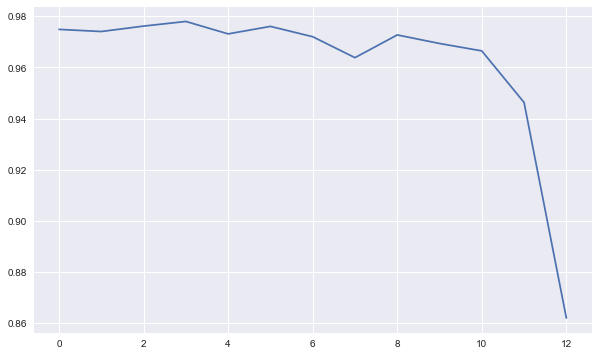

In [93]:
quals = []
for i in range(X.shape[1]):
    clf = RandomForestRegressor()
    clf.fit(X[:, imp_feature_idx[i:]], y)
    q = r2_score(y, clf.predict(X[:, imp_feature_idx[i:]]))
    quals.append(q)
plt.figure(figsize=(10, 6));
plt.plot(quals);

In [94]:
max(quals)

0.97801236762517219

## SelectFromModel

In [95]:
from sklearn.feature_selection import SelectFromModel

In [96]:
# Load the boston dataset.
boston = load_boston()
X, y = boston['data'], boston['target']

In [98]:
# We use the base estimator LassoCV since the L1 norm promotes sparsity of features.
clf = LassoCV()

# Set a minimum threshold of 0.25
sfm = SelectFromModel(clf, threshold=0.25)
sfm.fit(X, y)
n_features = sfm.transform(X).shape[1]

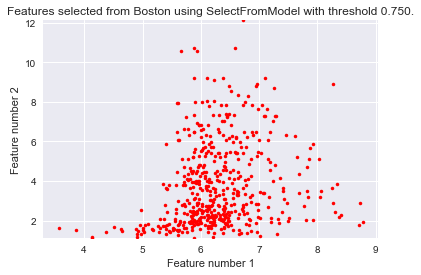

In [99]:
# Reset the threshold till the number of features equals two.
# Note that the attribute can be set directly instead of repeatedly
# fitting the metatransformer.
while n_features > 2:
    sfm.threshold += 0.1
    X_transform = sfm.transform(X)
    n_features = X_transform.shape[1]

# Plot the selected two features from X.
plt.title(
    "Features selected from Boston using SelectFromModel with "
    "threshold %0.3f." % sfm.threshold)
feature1 = X_transform[:, 0]
feature2 = X_transform[:, 1]
plt.plot(feature1, feature2, 'r.')
plt.xlabel("Feature number 1")
plt.ylabel("Feature number 2")
plt.ylim([np.min(feature2), np.max(feature2)])
plt.show()

# Перебор

## Exhaustive Feature Selector

In [100]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector

In [101]:
import warnings

In [102]:
efs = ExhaustiveFeatureSelector(Lasso(), 
           min_features=1,
           max_features=10,
           scoring='neg_mean_squared_error',
           print_progress=True,
           cv=5)

In [103]:
warnings.filterwarnings('ignore');
efs.fit(X, y);

Features: 8099/8099

In [104]:
print('Best accuracy score: %.2f' % efs.best_score_)
print('Best subset:', efs.best_idx_)

Best accuracy score: -33.13
Best subset: (0, 1, 7, 8, 9, 10, 11, 12)


## Sequential Feature Selector

In [292]:
from mlxtend.feature_selection import SequentialFeatureSelector

In [ ]:
sfs = SequentialFeatureSelector(Lasso(), 
           min_features=1,
           max_features=10,
           scoring='neg_mean_squared_error',
           print_progress=True,
           cv=5)

In [ ]:
warnings.filterwarnings('ignore');
sfs.fit(X, y);

# Что использовать?

* Методы фильтрации измеряют полезность признака, измеряя его корреляцию с целевой переменной, в то время как методы-обертки измеряют ценность определенного подмножества признаков, тренируя полноценную модель. В том числе это и значит, что будут учтены и взаимодействия признаков.
* Методы фильтрации работают намного быстрее, и на больших датасетах могут оказаться полезнее.
* Выводы в методах фильтрации делаются по статистическим тестам, в модельных методах - по результатам кросс-валидации.
* Модельные методы намного надежнее.
* Взятие меньшего подмножества признаков через модельный отбор защищает от переобучения. Подобного результата фильтрация не гарантирует.

# Ультра анализ

$$ y = 10\sin(\pi x_1x_2) + 20(x_3 – 0.5)^2+10x_4 + 5x_5 + \epsilon $$ 

In [105]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RandomizedLasso
from sklearn.feature_selection import RFE, f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

from minepy import MINE

In [106]:
size = 750
X = np.random.uniform(0, 1, (size, 14))
 
#"Friedamn #1” regression problem
Y = (10 * np.sin(np.pi*X[:,0]*X[:,1]) + 20*(X[:,2] - .5)**2 +
     10*X[:,3] + 5*X[:,4] + np.random.normal(0,1))

#Add 3 additional correlated variables (correlated with X1-X3)
X[:,10:] = X[:,:4] + np.random.normal(0, .025, (size,4))
names = ["x%s" % i for i in range(1,15)]

In [107]:
ranks = {}

def rank_to_dict(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks ))

In [108]:
lr = LinearRegression(normalize=True)
lr.fit(X, Y)
ranks["LinReg"] = rank_to_dict(np.abs(lr.coef_), names)

In [109]:
ridge = Ridge(alpha=7)
ridge.fit(X, Y)
ranks["Ridge"] = rank_to_dict(np.abs(ridge.coef_), names)

In [110]:
lasso = Lasso(alpha=.05)
lasso.fit(X, Y)
ranks["Lasso"] = rank_to_dict(np.abs(lasso.coef_), names)

In [111]:
rlasso = RandomizedLasso(alpha=0.04)
rlasso.fit(X, Y)
ranks["Stab"] = rank_to_dict(np.abs(rlasso.scores_), names)

In [112]:
#stop the search when 5 features are left (they will get equal scores)
rfe = RFE(lr, n_features_to_select=5)
rfe.fit(X,Y)
ranks["RFE"] = rank_to_dict(np.array(list(map(float, rfe.ranking_))), names, order=-1)

In [113]:
rf = RandomForestRegressor()
rf.fit(X,Y)
ranks["RF"] = rank_to_dict(rf.feature_importances_, names)

In [114]:
f, pval  = f_regression(X, Y, center=True)
ranks["Corr."] = rank_to_dict(f, names)

In [115]:
mine = MINE()
mic_scores = []
for i in range(X.shape[1]):
    mine.compute_score(X[:,i], Y)
    m = mine.mic()
    mic_scores.append(m)

ranks["MIC"] = rank_to_dict(mic_scores, names) 

In [116]:
r = {}
for name in names:
    r[name] = round(np.mean([ranks[method][name] for method in ranks.keys()]), 2)

In [117]:
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")

In [118]:
print("\t%s" % "\t".join(methods))
for name in names:
    print("%s\t%s" % (name, "\t".join(map(str, [ranks[method][name] for method in methods]))))

	Corr.	Lasso	LinReg	MIC	RF	RFE	Ridge	Stab	Mean
x1	0.37	0.51	0.5	0.53	0.48	1.0	0.7	0.61	0.59
x2	0.41	0.49	0.52	0.56	0.58	1.0	0.65	0.62	0.6
x3	0.0	0.01	0.56	0.33	0.09	1.0	0.09	0.0	0.26
x4	1.0	1.0	1.0	1.0	0.68	1.0	1.0	1.0	0.96
x5	0.14	0.51	0.54	0.24	0.36	1.0	0.9	0.66	0.54
x6	0.0	0.0	0.0	0.13	0.0	0.0	0.01	0.0	0.02
x7	0.01	0.0	0.05	0.11	0.0	0.44	0.09	0.0	0.09
x8	0.0	0.0	0.01	0.0	0.01	0.22	0.02	0.0	0.03
x9	0.0	0.0	0.02	0.09	0.02	0.33	0.03	0.0	0.06
x10	0.0	0.0	0.0	0.13	0.0	0.11	0.0	0.0	0.03
x11	0.36	0.25	0.27	0.47	0.5	0.78	0.68	0.33	0.46
x12	0.41	0.21	0.19	0.52	0.5	0.67	0.63	0.5	0.45
x13	0.0	0.0	0.48	0.21	0.1	0.89	0.02	0.0	0.21
x14	0.99	0.1	0.09	1.0	1.0	0.56	0.95	0.59	0.66


With linear correlation (Lin. corr.), each feature is evaluated independently, so the scores for features x1…x4 are very similar to x11…x14, while the noise features x5…x10 are correctly identified to have almost no relation with the response variable. It’s not able to identify any relationship between x3 and the response variable, since the relationship is quadratic (in fact, this applies almost all other methods except for MIC). It’s also clear that while the method is able to measure the linear relationship between each feature and the response variable, it is not optimal for selecting the top performing features for improving the generalization of a model, since all top performing features would essentially be picked twice.

Lasso picks out the top performing features, while forcing other features to be close to zero. It is clearly useful when reducing the number of features is required, but not necessarily for data interpretation (since it might lead one to believe that features x11…x13 do not have a strong relationship with the output variable).

MIC is similar to correlation coefficient in treating all features “equally”, additionally it is able to find the non-linear a relationship between x3 and the response.

Random forest’s impurity based ranking is typically aggressive in the sense that there is a sharp drop-off of scores after the first few top ones. This can be seen from the example where the third ranked feature has already 4x smaller score than the top feature (whereas for the other ranking methods, the drop-off is clearly not that aggressive).

Ridge regression forces regressions coefficients to spread out similarly between correlated variables. This is clearly visible in the example where x11…x14 are close to x1…x4 in terms of scores.

Stability selection is often able to make a useful compromise between data interpretation and top feature selection for model improvement. This is illustrated well in the example. Just like Lasso it is able to identify the top features (x1, x2, x4, x5). At the same time their correlated shadow variables also get a high score, illustrating their relation with the response.